# First Test

Very simple 1D model to try the integration of empymod into SimPEG.

Limiations at this point:

- Inversion only for infinitesimal small x-directed electric source and receiver (ab == 11)
- Frequency domain
- Inversion only for resistivity ($\rho_h$), hence fixed values for anisotropy ($\lambda$), electric permeabilities ($\epsilon_h$, $\epsilon_v$) and magnetic permeabilities ($\mu_h$, $\mu_v$)
- Fixed depth structure (ont inverting for layer thicknesses)
- No `numexpr`

## Other considerations

- SimPEG supports, I think, Python 2.7 and 3+, however, empymod only supports Python 3.4, 3.5, 3.6.

Shall we first try only one frequency and one offset? Or several frequencies, one offset? Or several offsets, one frequency?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import SimPEG
import empymod

## Define forward model

Lets define a simple forward model to generate some data, the canonical CSEM model (e.g., Constable and Weiss, 2006). We define only the minimum required input, and leave everything else at its default value.

In [2]:
depth = [ 0, 1000, 2000, 2100] # Layer boundaries
res =   [2e14, .3, 1, 100, 1]  # Air, sea, overburden, target, underburden
freq = 1                       # 1 Hz
src = [0, 0, 900]              # Src coordinates
x = np.arange(2, 8)*1000       # Offsets
rec = [x, x*0, 1000]           # Rec coordinates

data = empymod.dipole(src, rec, depth, res, freq)

# Lets also calculate a denser model and the background, just to compare it
xf = np.arange(1, 80)*100       # Offsets
rec2 = [xf, xf*0, rec[2]]
full = empymod.dipole(src, rec2, depth, res, freq)
bg = empymod.dipole(src, rec2, depth[:-2], res[:-2], freq)


:: empymod END; runtime = 0:00:00.010553 :: 1 kernel call(s)


:: empymod END; runtime = 0:00:00.048450 :: 1 kernel call(s)


:: empymod END; runtime = 0:00:00.029228 :: 1 kernel call(s)



### Add some noise data

Add 1 % random error and a noise level of 10e-15 V/m.

In [3]:
# Generate noise
mask = 1e-2*(1.5 - np.random.random_sample(data.shape))
maskn = 1e-15*(1.5 - np.random.random_sample(data.shape))

# Apply noise
datan = data*(1 + mask) + maskn

## Plot model and data

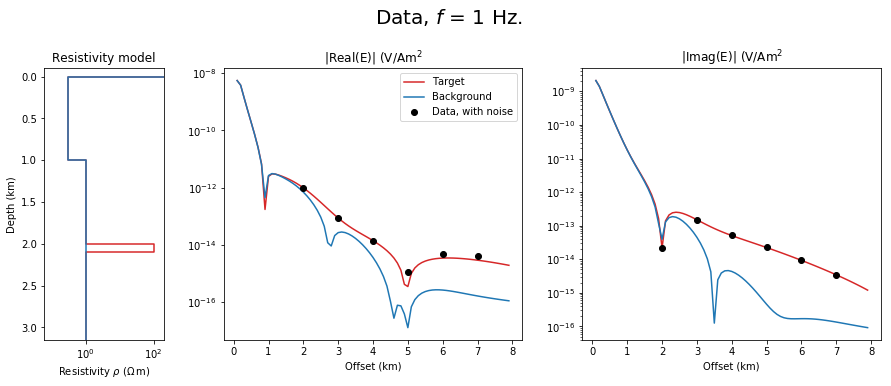

In [4]:
# Create arrays for resistivity model
pdepth = np.repeat(np.r_[-100, depth], 2)
pdepth[:-1] = pdepth[1:]
pdepth[-1] = 2*depth[-1]
pres = np.repeat(res, 2)
presBG = np.repeat(res[:-2], 2)

# Create figure
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=.5)
plt.suptitle('Data, $f$ = '+str(freq)+' Hz.', y=1.05, fontsize=20)

# Plot Resistivities
plt.subplot(151)
plt.title('Resistivity model')
plt.plot(pres, pdepth/1000, 'C3', label='Target')
plt.plot(presBG, np.r_[pdepth[:-5], pdepth[-1]]/1000, 'C0', label='BG')
plt.xscale('log')
plt.xlim([.2*np.array(res).min(), 2*np.array(res)[1:].max()])
plt.ylim([1.5*depth[-1]/1000, -0.1])
plt.ylabel('Depth (km)')
plt.xlabel(r'Resistivity $\rho\ (\Omega\,\rm{m})$')

# Plot Amplitude
plt.subplot2grid((1, 5), (0, 1), colspan=2)
plt.title(r'|Real(E)| (V/Am$^2$')
plt.semilogy(xf/1000, np.abs(full.real), 'C3', label='Target')
plt.semilogy(xf/1000, np.abs(bg.real), 'C0', label='Background')
plt.semilogy(x/1000, np.abs(datan.real), 'ko', label='Data, with noise')
plt.legend(loc='best')
plt.xlabel('Offset (km)')

# Plot Phase
plt.subplot2grid((1, 5), (0, 3), colspan=2)
plt.title(r'|Imag(E)| (V/Am$^2$')
plt.semilogy(xf/1000, np.abs(full.imag), 'C3', label='Target')
plt.semilogy(xf/1000, np.abs(bg.imag), 'C0', label='Background')
plt.semilogy(x/1000, np.abs(datan.imag), 'ko', label='Data, with noise')
plt.xlabel('Offset (km)')

plt.show()

## Define inverse model

The main user-facing routines of `empymod` are `model.dipole` and `model.bipole`. However, they do a lot of stuff we want to avoid in an inversion scheme, such as input checks and timing.

In [5]:
imodel = {}

In [6]:
import printinfo
printinfo.info()